In [ ]:
%%capture

! pip install datasets transformers evaluate

## Load a dataset

Let's start by loading a small image classification dataset and taking a look at its structure.



In [ ]:
from datasets import load_dataset

dataset_name = "jonathan-roberts1/Satellite-Images-of-Hurricane-Damage"

def get_ds():
  ds = load_dataset(dataset_name)
  ds = ds["train"].train_test_split(test_size=0.5)
  ds["train"]["label"].count(1), ds["test"]["label"].count(0)
  ds_ = ds["test"].train_test_split(test_size=0.5)
  ds["validation"] = ds_["train"]
  ds["test"] = ds_["test"]
  return ds

ds = get_ds()

Let's take a look at the 400th example from the `'train'` split from the dataset. You'll notice each example from the dataset has 2 features:

1. `image`: A PIL Image
1. `image_file_path`: The `str` path to the image file that was loaded as `image`
1. `labels`: A [`datasets.ClassLabel`](https://huggingface.co/docs/datasets/package_reference/main_classes.html?highlight=classlabel#datasets.ClassLabel) feature, which we'll see as an integer representation of the label for a given example. (Later we'll see how to get the string class names, don't worry)

In [ ]:
ex = ds['train'][400]
ex

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=128x128>,
 'label': 0}

Let's take a look at the image 👀

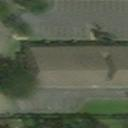

In [ ]:
image = ex['image']
image

Since the `'labels'` feature of this dataset is a `datasets.features.ClassLabel`, we can use it to lookup the corresponding name for this example's label ID.

First, lets access the feature definition for the `'label'`.

In [ ]:
ds

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 5000
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 2500
    })
    validation: Dataset({
        features: ['image', 'label'],
        num_rows: 2500
    })
})

In [ ]:
labels = ds['train'].features['label']
labels

ClassLabel(names=['flooded or damaged buildings', 'undamaged buildings'], id=None)

Now, lets print out the class label for our example. We'll do that by using the [`int2str`](https://huggingface.co/docs/datasets/package_reference/main_classes.html?highlight=classlabel#datasets.ClassLabel.int2str) function of `ClassLabel`, which, as the name implies, lets us pass the int representation of the class to look up the string label.

In [ ]:
labels.int2str(ex['label'])

'flooded or damaged buildings'

Let's write a function that'll display a grid of examples from each class so we can get a better idea of what we're working with.

Filter:   0%|          | 0/5000 [00:00<?, ? examples/s]

Filter:   0%|          | 0/5000 [00:00<?, ? examples/s]

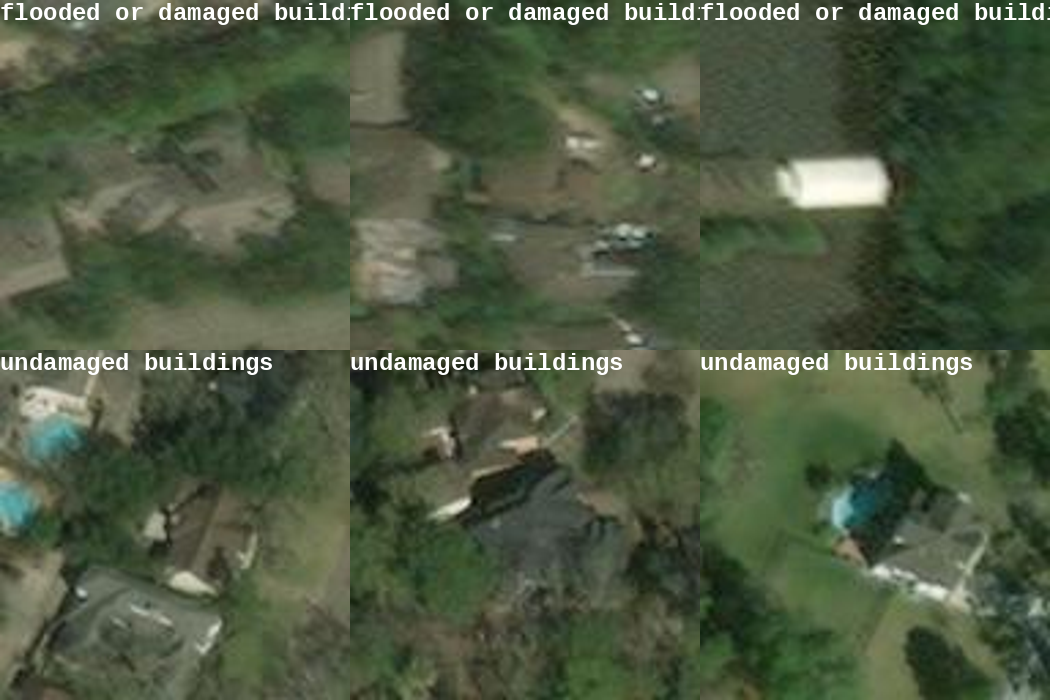

In [ ]:
from transformers.utils.dummy_vision_objects import ImageGPTFeatureExtractor
import random
from PIL import ImageDraw, ImageFont, Image

def show_examples(ds, seed: int = 1234, examples_per_class: int = 3, size=(350, 350)):

    w, h = size
    labels = ds['train'].features['label'].names
    grid = Image.new('RGB', size=(examples_per_class * w, len(labels) * h))
    draw = ImageDraw.Draw(grid)
    font = ImageFont.truetype("/usr/share/fonts/truetype/liberation/LiberationMono-Bold.ttf", 24)

    for label_id, label in enumerate(labels):

        # Filter the dataset by a single label, shuffle it, and grab a few samples
        ds_slice = ds['train'].filter(lambda ex: ex['label'] == label_id).shuffle(seed).select(range(examples_per_class))

        # Plot this label's examples along a row
        for i, example in enumerate(ds_slice):
            image = example['image']
            idx = examples_per_class * label_id + i
            box = (idx % examples_per_class * w, idx // examples_per_class * h)
            grid.paste(image.resize(size), box=box)
            draw.text(box, label, (255, 255, 255), font=font)

    return grid

show_examples(ds, seed=random.randint(0, 1337), examples_per_class=3)